<a href="https://colab.research.google.com/github/kai-neuhaus/OCT_reader/blob/master/OCT_reader_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is only for colab demo.

For local running code use OCT_reader.py on GitHub.

Run all cells the first time: Menu "Runtime - Run all".

Scroll to the last cell output. \
The last cell can be modified and called repeatedly.

Additional modules to be installed should be 'xmltodict' and 'shutil'.

We install for colab also 'gdown' to download some example OCT file.

# Other aspects
## Unzipping the OCT file
The function unzip_OCTFile(```<fname>```) is in fact just extracting all files into a temporary folder.

## xmltodict
The xmltodict module is used to read the Header.xml into a dictionary.

Find the line in the unzip_OCTFile
```    
    handle_xml = xmltodict.parse(xmldoc)
    handle.update(handle_xml)
 ```
where the content of the ```Header.xml``` is converted into a dictionary ```handle_xml``` and added to the dictionary ```handle```.

Although the metadata parameters, such as __SizeX__ or __SizeZ__ etc., can be hardcoded for some one-off processing, the use of the dictionary makes it possible to read for different OCT files and different imaging data.



In [10]:
# import xmltodict and install if required
# Must run in separate cell such that install can finish
try:
  import xmltodict
except ModuleNotFoundError as e:
  !pip install xmltodict
  import xmltodict

In [11]:
# Import gdown and install if required
# Must run in separate cell such that install and download can finish
# https://kobkrit.com/how-to-directly-download-files-from-dropbox-or-google-drive-using-wget-in-terminal-or-in-google-573168195011    
try:
  import gdown
except ModuleNotFoundError as e:
  !pip install gdown 
  

In [12]:
print('xmltodict: ',xmltodict.__version__)
print('gdown: ',gdown.__version__)
import os
# download data if not exist
# must run in separate cell to finish befor next cell
if not os.path.exists('/content/AfterCXL2D(2).oct'):
  !gdown --id '18xtWgvMdHw3OslDyyXZ6yMKDywhj_zdR'
  # import gdown

xmltodict:  0.12.0
gdown:  3.6.4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Reuse data in /tmp/OCTData/AfterCXL2D(2)



properties:
dict_keys(['filename', 'path', 'named_oct_data_folder', 'Ocity'])
odict_keys(['@version', 'DataFiles', 'Image', 'Acquisition', 'Processing', 'PolarizationProcessing', 'Instrument', 'MetaInfo', 'MarkerList'])
odict_keys(['IntensityAveraging', 'DopplerAveraging', 'SpeckleAveraging', 'Timestamp', 'ScanTime', 'ScanPause', 'RefractiveIndex', 'ReferenceIntensity', 'Saturation', 'Oversampling', 'ApodizationType', 'AcquisitionOrder'])
AfterCXL
1.370000
odict_keys(['FastAxis', 'SlowAxis'])
Speckle Averaging FastAxis:  1
odict_keys(['@Type', 'SizePixel', 'SizeReal', 'PixelSpacing', 'DataType', 'AxisOrder', 'CenterX', 'CenterY', 'Angle', 'Zoom', 'FreeformScanPatternIsActive', 'FreeformScanPatternCloseLoop', 'FreeformScanPatternInterpolation', 'MinPointDistance', 'MaxPointDistance'])


data file names:
data\VideoImage.data
data\Intensity.data
data\Spectral0.data
data\Spectral1.data
data\Chirp.data
data\ApodizationSpectrum.data
data\OffsetErrors.data
data\Probe.ini
Colored
Real
OrderedD

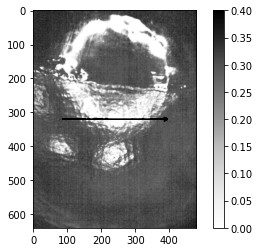

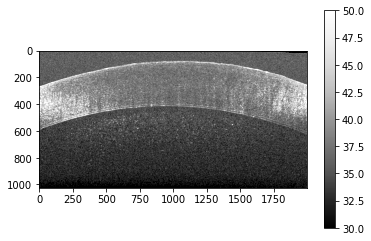

In [13]:
import numpy as np
import matplotlib.pyplot as pp
import tempfile
import zipfile
import shutil
import json
import warnings
from warnings import warn
# formatwarning_orig = warnings.formatwarning
# warnings.formatwarning = lambda message, category, filename, lineno, line=None: \
    # formatwarning_orig(message, category, filename='', lineno='', line='')


def unzip_OCTFile(filename):
    """
    Unzip the OCT file into a temp folder.

    :param filename:
    :return:
    """
    tempdir = tempfile.gettempdir()
    handle = dict()
    handle['filename'] = filename
    handle['path'] = os.path.join(tempdir, 'OCTData')



    named_oct_data_folder = os.path.join(handle['path'],os.path.basename(filename).strip('.oct'))
    handle['named_oct_data_folder'] = named_oct_data_folder
    if os.path.exists(named_oct_data_folder):
        warn('Reuse data in {}\n'.format(named_oct_data_folder))
    else:
        print('\nTry to extract {} into {}. Please wait.\n'.format(filename,named_oct_data_folder))
        if not os.path.exists(handle['path']):
            os.mkdir(handle['path'])
        if not os.path.exists(named_oct_data_folder):
            os.mkdir(named_oct_data_folder)

        with zipfile.ZipFile(file=handle['filename']) as zf:
            zf.extractall(path=named_oct_data_folder)

        # Thorlabs stores incompatible folder names in zip.
        # Need to create data explicitly.
        # walk_object = os.walk(named_oct_data_folder)
        # for root, dirs, files in walk_object:
        #     if not os.path.exists(os.path.join(named_oct_data_folder, 'data')):
        #         os.mkdir(os.path.join(named_oct_data_folder, 'data'))
        #     for file in files:
        #         if not 'Header.xml' in file:
        #             src = os.path.join(root, file)
        #             dst = os.path.join(root,'data',file.lstrip('data\\\\'))
        #             shutil.move(src,dst)

    # make folder 's' to indicate it is in use (open)
    if not os.path.exists(os.path.join(named_oct_data_folder,'s')):
        os.mkdir(os.path.join(named_oct_data_folder,'s'))
    else:
        warn('Folder \'s\' exists.')

    with open(os.path.join(named_oct_data_folder, 'Header.xml'),'rb') as fid:
        up_to_EOF = -1
        xmldoc = fid.read(up_to_EOF)

    handle_xml = xmltodict.parse(xmldoc)
    handle.update(handle_xml)
    return handle

def get_OCTDataFileProps(handle, data_name=None, prop=None):
    """
    List some of the properties as in the Header.xml.
    :param handle:
    :param data_name:
    :param prop:
    :return:
    """
    metadatas = handle['Ocity']['DataFiles']['DataFile']
    metadata = metadatas[np.argwhere([data_name in h['#text'] for h in handle['Ocity']['DataFiles']['DataFile']]).squeeze()]
    prop = metadata[prop]
    return prop

def get_OCTFileMetaData(handle, data_name):
    # Update data types if required
    python_dtypes = {'Colored':{'4':np.int32, '2':np.int16}, 'Real':{'4':np.float32}, 'Raw':{'2':np.uint16}}
    handle.update({'python_dtypes':python_dtypes})

    # Check if data_name is available
    data_names_available = [d['#text'] for d in handle['Ocity']['DataFiles']['DataFile']]
    data_name = 'data\\'+data_name+'.data' # check this on windows
    assert data_name in data_names_available, 'Did not find {}.\nAvailable names are: {}'.format(data_name,data_names_available)

    metadatas = handle['Ocity']['DataFiles']['DataFile'] # get list of all data files
    # select the data file matching data_name
    metadata = metadatas[np.argwhere([data_name in h['#text'] for h in handle['Ocity']['DataFiles']['DataFile']]).squeeze()]
    print(metadata)
    return handle, metadata

def get_OCTVideoImage(handle):
    """
    Examples how to extract VideoImage data
    :param handle:
    :param data_name:
    :return:
    """
    handle, metadata = get_OCTFileMetaData(handle, 'VideoImage')
    data_filename = os.path.join(handle['named_oct_data_folder'], metadata['#text'])
    img_type = metadata['@Type']
    dtype = handle['python_dtypes'][img_type][metadata['@BytesPerPixel']] # This is not consistent! unsigned and signed not distinguished!
    sizeX = int(metadata['@SizeX'])
    sizeZ = int(metadata['@SizeZ'])
    data = np.fromfile(data_filename, dtype).reshape([sizeX,sizeZ])
    data = abs(data)/abs(data).max()
    return data

def get_OCTIntensityImage(handle):
    """
    Example how to extract Intensity data
    :param handle:
    :return:
    """
    handle, metadata = get_OCTFileMetaData(handle, data_name='Intensity')
    data_filename = os.path.join(handle['named_oct_data_folder'], metadata['#text'])
    img_type = metadata['@Type'] # this is @Real
    dtype = handle['python_dtypes'][img_type][metadata['@BytesPerPixel']] # This is not consistent! unsigned and signed not distinguished!
    sizeX = int(metadata['@SizeX'])
    sizeZ = int(metadata['@SizeZ'])
    data = (np.fromfile(data_filename, dtype=(dtype, [sizeX,sizeZ])))[0].T # there are two images. Take the first [0].
    return data

def get_OCTSpectralImage(handle):
    handle, metadata = get_OCTFileMetaData(handle, data_name='Spectral0')
    data_filename = os.path.join(handle['named_oct_data_folder'], metadata['#text'])
    img_type = metadata['@Type'] # this is @Real
    dtype = handle['python_dtypes'][img_type][metadata['@BytesPerPixel']] # This is not consistent! unsigned and signed not distinguished!
    sizeX = int(metadata['@SizeX'])
    sizeZ = int(metadata['@SizeZ'])
    data = (np.fromfile(data_filename, dtype=(dtype, [sizeX,sizeZ])))[0].T # there are two images. Take the first [0].
    # metadata['Ocity'][]
    return data

def close_OCTFile(handle):
    """
    remove 's' folder.
    :param handle:
    :return:
    """

    if os.path.exists(os.path.join(handle['named_oct_data_folder'],'s')):
      os.rmdir(os.path.join(handle['named_oct_data_folder'], 's'))
    else:
      warn('Subfolder \'s\' as label not existing.')



# Example usage
handle = unzip_OCTFile('/content/AfterCXL2D(2).oct');

# example to list properties
print('properties:')
print(handle.keys()) #list all keys in handle
print(handle['Ocity'].keys()) #list all keys in Ocity. This is from Header.xml
print(handle['Ocity']['Acquisition'].keys()) #list all keys in Acquisition
print(handle['Ocity']['MetaInfo']['Comment']) #get comment value from MetaInfo

print(handle['Ocity']['Acquisition']['RefractiveIndex'])
print(handle['Ocity']['Acquisition']['SpeckleAveraging'].keys())
fastaxis = handle['Ocity']['Acquisition']['SpeckleAveraging']['FastAxis']
print('Speckle Averaging FastAxis: ',fastaxis)
print(handle['Ocity']['Image'].keys())

# example list all data files
print('\n\ndata file names:')
[print(h['#text']) for h in handle['Ocity']['DataFiles']['DataFile']]

print(get_OCTDataFileProps(handle, data_name = 'VideoImage', prop='@Type')) #print type of video image
print(get_OCTDataFileProps(handle, data_name = 'Intensity', prop='@Type'))

# get and plot VideoImage
data = get_OCTVideoImage(handle)
pp.figure(num='VideoImage')
pp.imshow(data,cmap='Greys',vmin=0.0,vmax=0.4)
pp.colorbar()

# get and plot IntensityImage
data = get_OCTIntensityImage(handle)
pp.figure(num='Intensity')
pp.imshow((data))
pp.imshow(data,cmap='Greys_r',vmin=30,vmax=50)
pp.colorbar()

# data = get_OCTSpectralImage(handle)

pp.show()

close_OCTFile(handle)
